In [1]:
from __future__ import print_function

import csv
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from scipy.stats import kde

from hp import HP
from rl_memory import Memory

%matplotlib inline

dev = "cuda:0"

In [2]:
class Net(nn.Module):
    
    # Input is one hot encoding of the protein and its conformation
    # Output is the value of changing a given angle to another angle
    
    def __init__(self,n):
        super(Net,self).__init__()
        self.n = n
        self.fc1 = nn.Linear(5*n,2048)
        self.fc2 = nn.Linear(2048,256)
        self.fc3 = nn.Linear(256,3*n)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self,x):
        x = x.view(-1,5*self.n)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = x.view(-1,self.n,3)
        return x
    
    def value(self,x):
        return self.forward(x).view(-1,3*self.n).max(1).values        

In [3]:
def main_loop():
    
    energies = []
    
    for i in range(NUM_EPISODES):
        
        hp = HP.random(30)
        state = hp.make_state(dev=dev)
        
        for j in range(NUM_STEPS):
            
            if random.random() < EXPLORE:
                action = random_action()
            else:
                action = policy_net(state)
                
            next_state, reward = perform_action(state, action)
            memory.push(state, action, next_state, reward)
            state = next_state
            optimize_model()
            
        hp = state2hp(state)
        e = hp.energy()
        energies.append(e)
        sys.stdout.write("\r%d, %s, %s, %f     " % (i, hp.sequence, hp.conformation, e))
                        
        value_net.load_state_dict(policy_net.state_dict())
        
    return energies
            
def state2hp(state):
    return HP.create_from_one_hots(state[:,:2], state[:PROTEIN_LENGTH-1,2:5]) 

def random_action():
    a = torch.zeros(1,PROTEIN_LENGTH,3)
    a = a.to(dev)
    i = random.randint(0,29)
    j = random.randint(0,2)
    a[0][i][j] = 1
    return a

def perform_action(state, action):
    n = len(action[0])
    a = action.view(-1,3*n).argmax(-1)
    i, j = int(a/3), int(a%3)
    new_state = state.clone()
    new_state[i][2] = 0
    new_state[i][3] = 0
    new_state[i][4] = 0    
    new_state[i][j+2] = 1
    return new_state, state2hp(state).energy() - state2hp(new_state).energy()

def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    
    states, next_states, actions, rewards = memory.sample(BATCH_SIZE)
    estimates = policy_net.value(states)
    targets = GAMMA * value_net.value(next_states) + rewards
    loss = loss_function(estimates, targets)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), GRAD_CLIP)
    optimizer.step()
    

In [4]:
PROTEIN_LENGTH = 30
NUM_EPISODES = 4000
NUM_STEPS = 500
MEM_SIZE = 200000
BATCH_SIZE = 128
GAMMA = 0.9999
LR = 0.0001
GRAD_CLIP = 0.25
EXPLORE = 0.05

policy_net = Net(PROTEIN_LENGTH)
policy_net.to(dev)
value_net = Net(PROTEIN_LENGTH)
value_net.to(dev)

memory = Memory(MEM_SIZE,dev)

loss_function = nn.MSELoss()
optimizer = optim.Adam(policy_net.parameters(),  lr=LR)

energies = main_loop()

3999, PHHPPPHPHPHPPPHHPHPPPHHPPHHHHP, SLSLLSRLLLSRSSRSSSLSSSLRSLSSL, 497.000000      

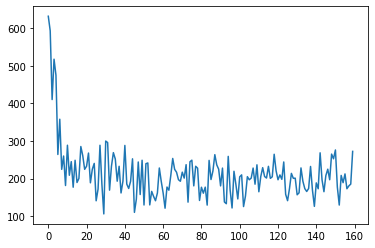

In [39]:
M = 25
x = [sum(energies[M*i:M*(i+1)])/M for i in range(int(len(energies)/M))]
plt.plot(x);

In [46]:
states, next_states, actions, rewards = memory.sample(50*BATCH_SIZE)
rewards.argmax()

tensor(5834, device='cuda:0')

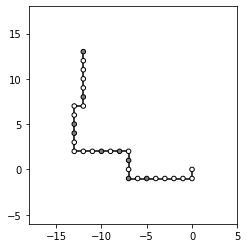

In [47]:
state2hp(states[22]).show(plt.gca())